In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Memuat data
# Pastikan file application_train.csv ada di folder yang sama
df = pd.read_csv('application_train.csv')

print("Ukuran Data:", df.shape)
print("\nStatistik Deskriptif Target (Imbalance Check):")
print(df['TARGET'].value_counts(normalize=True))

# Cek Missing Values
missing = df.isnull().sum().sort_values(ascending=False)
print("\n10 Kolom dengan Missing Values Terbanyak:")
print(missing.head(10))

Ukuran Data: (307511, 122)

Statistik Deskriptif Target (Imbalance Check):
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

10 Kolom dengan Missing Values Terbanyak:
COMMONAREA_AVG              214865
COMMONAREA_MODE             214865
COMMONAREA_MEDI             214865
NONLIVINGAPARTMENTS_MEDI    213514
NONLIVINGAPARTMENTS_MODE    213514
NONLIVINGAPARTMENTS_AVG     213514
FONDKAPREMONT_MODE          210295
LIVINGAPARTMENTS_AVG        210199
LIVINGAPARTMENTS_MEDI       210199
LIVINGAPARTMENTS_MODE       210199
dtype: int64


In [10]:
# 1. Menangani anomali pada DAYS_EMPLOYED
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# 2. Label Encoding untuk kolom kategorikal dengan 2 nilai unik
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            df[col] = le.fit_transform(df[col])

# 3. One-Hot Encoding untuk sisanya
df = pd.get_dummies(df)

# 4. Imputasi nilai kosong dengan median
train_labels = df['TARGET']
train_df = df.drop(columns = ['TARGET', 'SK_ID_CURR'])

imputer = SimpleImputer(strategy = 'median')
train_features = imputer.fit_transform(train_df)

# 5. Scaling data
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

print("Proses Pembersihan Selesai. Data siap dimodelkan.")

C:\Users\Reski_Anugrah_Sari\AppData\Local\Temp\ipykernel_12792\2960473333.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)


Proses Pembersihan Selesai. Data siap dimodelkan.


Korelasi Terkuat (Negatif): 
 EXT_SOURCE_3   -0.178919
EXT_SOURCE_2   -0.160472
EXT_SOURCE_1   -0.155317
Name: TARGET, dtype: float64

Korelasi Terkuat (Positif): 
 REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


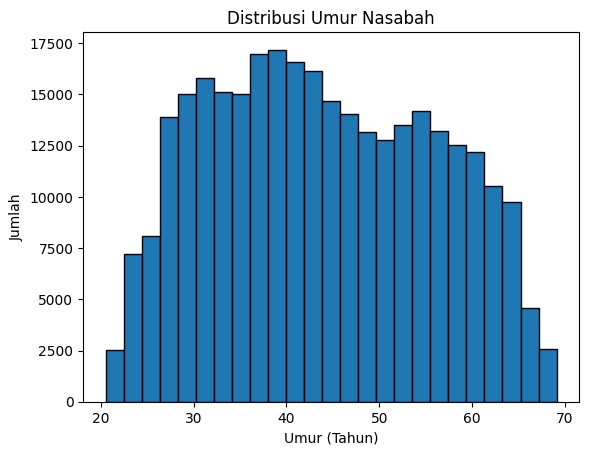

In [11]:
# Melihat korelasi fitur terhadap target
correlations = df.corr()['TARGET'].sort_values()
print("Korelasi Terkuat (Negatif): \n", correlations.head(3))
print("\nKorelasi Terkuat (Positif): \n", correlations.tail(4))

# Visualisasi distribusi umur (DAYS_BIRTH) dalam tahun
plt.hist(df['DAYS_BIRTH'] / -365, edgecolor = 'k', bins = 25)
plt.title('Distribusi Umur Nasabah'); plt.xlabel('Umur (Tahun)'); plt.ylabel('Jumlah');
plt.show()

Korelasi Terkuat (Negatif): 
 EXT_SOURCE_3   -0.178919
EXT_SOURCE_2   -0.160472
EXT_SOURCE_1   -0.155317
Name: TARGET, dtype: float64

Korelasi Terkuat (Positif): 
 REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


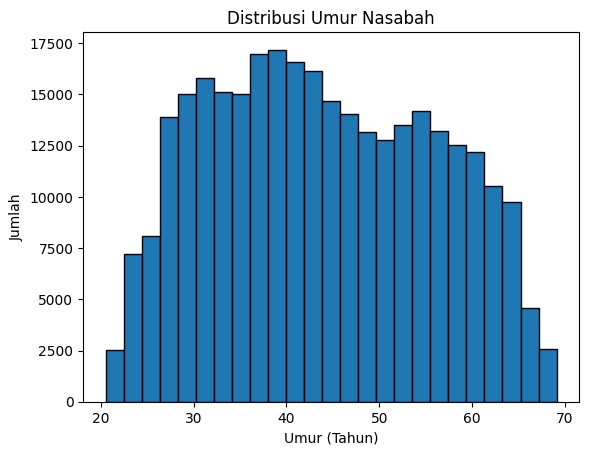

In [12]:
# Melihat korelasi fitur terhadap target
correlations = df.corr()['TARGET'].sort_values()
print("Korelasi Terkuat (Negatif): \n", correlations.head(3))
print("\nKorelasi Terkuat (Positif): \n", correlations.tail(4))

# Visualisasi distribusi umur (DAYS_BIRTH) dalam tahun
plt.hist(df['DAYS_BIRTH'] / -365, edgecolor = 'k', bins = 25)
plt.title('Distribusi Umur Nasabah'); plt.xlabel('Umur (Tahun)'); plt.ylabel('Jumlah');
plt.show()

In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Model 1: Logistic Regression dengan Hyperparameter C (Regularization)
log_reg = LogisticRegression(C = 0.0001, solver='lbfgs', max_iter=100)
log_reg.fit(X_train, y_train)

# Model 2: Random Forest (sebagai pembanding)
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

print("Pemodelan selesai.")

Pemodelan selesai.


Logistic Regression AUC: 0.7447
Random Forest AUC: 0.7217


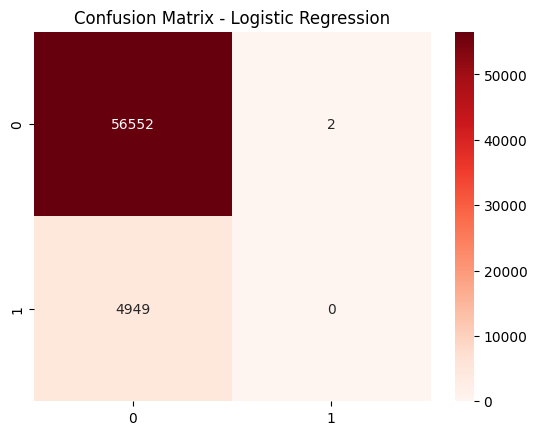

In [14]:
# Prediksi probabilitas
log_pred = log_reg.predict_proba(X_test)[:, 1]
rf_pred = rf.predict_proba(X_test)[:, 1]

# Skor AUC
print(f"Logistic Regression AUC: {roc_auc_score(y_test, log_pred):.4f}")
print(f"Random Forest AUC: {roc_auc_score(y_test, rf_pred):.4f}")

# Confusion Matrix Logistic Regression
sns.heatmap(confusion_matrix(y_test, log_reg.predict(X_test)), annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [15]:
# Menghitung dampak (Simulasi sederhana)
n_detected_default = confusion_matrix(y_test, log_reg.predict(X_test))[1,1]
avg_loan = df['AMT_CREDIT'].mean()

print(f"Rekomendasi Bisnis:")
print(f"1. Model berhasil mendeteksi {n_detected_default} nasabah yang berpotensi gagal bayar.")
print(f"2. Potensi penghematan biaya risiko: Rp {n_detected_default * avg_loan:,.2f}")
print(f"3. Tindakan: Lakukan pengetatan verifikasi pada nasabah dengan skor probabilitas > 0.1")

Rekomendasi Bisnis:
1. Model berhasil mendeteksi 0 nasabah yang berpotensi gagal bayar.
2. Potensi penghematan biaya risiko: Rp 0.00
3. Tindakan: Lakukan pengetatan verifikasi pada nasabah dengan skor probabilitas > 0.1
